In [1]:
#%matplotlib inline
from __future__ import print_function
import pylab

import numpy as np

import matplotlib.pyplot as plt
import time
import os
import pickle
import random

import pandas as pd

import random

#from category_encoders import *

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

plt.style.use('seaborn-white')

pylab.ion()

In [2]:
import scipy.integrate as integrate
from numpy import sqrt, sin, cos, pi, tan, sinh, cosh, exp, tanh, log, log10
import scipy.special as ssf
import math

In [3]:
def psiHOpoint(n, x):
    return exp(-0.5*x*x)*ssf.hermite(n)(x)/sqrt(math.factorial(n)*sqrt(pi)*2**n)

def psiHO(n, x):
    x=np.array(x)
    return exp(-0.5*x*x)*ssf.hermite(n)(x)/sqrt(math.factorial(n)*sqrt(pi)*2**n)

def psiHOall(n, x):
    return np.array([psiHO(i, x) for i in range(n+1)])

def HM(n, x):
    return np.array([psiHO(i, x) for i in range(n+1)]).T

def FM(k, L, x): #k Fourier modes in the interval (-L,L)
    x=np.array(x)
    xkmat = np.reshape(x, [len(x),1])*np.array(range(1,k+1))
    zeromode = 1/sqrt(2*L)*np.ones([len(x),1])
    cosmodes = cos(xkmat*pi/L)/sqrt(L)
    sinmodes = sin(xkmat*pi/L)/sqrt(L)
    return np.concatenate((zeromode,cosmodes,sinmodes),axis=1)

def FCpsiHO(n, k, L) :#k Fourier coefficients for the nth harmonic oscillator wavefunction in (-L,L)
    coeff0 = np.array([integrate.quad(lambda x: psiHOpoint(n, x)/sqrt(2*L), -L, L)[0]])
    coeffcos = np.array([integrate.quad(lambda x: psiHOpoint(n, x)*cos(x*i*pi/L)/sqrt(L), -L, L)[0] \
                         for i in range(1,k+1)])
    coeffsin = np.array([integrate.quad(lambda x: psiHOpoint(n, x)*sin(x*i*pi/L)/sqrt(L), -L, L)[0] \
                         for i in range(1,k+1)])
    return np.concatenate((coeff0,coeffcos,coeffsin))

In [4]:
def FM0(k, L, x): #k Fourier modes in the interval (-L,L)
    kvec = np.array(range(1,k+1))
    zeromode = 1/sqrt(2*L)
    cosmodes = cos(kvec*x*pi/L)/sqrt(L)
    sinmodes = sin(kvec*x*pi/L)/sqrt(L)
    return np.concatenate(([zeromode],cosmodes,sinmodes))

def D2FM0(k, L, x): #second derivative of k Fourier modes in the interval (-L,L)
    kvec = np.array(range(1,k+1))
    zeromode = 0
    cosmodes = -(kvec*pi/L)**2*cos(kvec*x*pi/L)/sqrt(L)
    sinmodes = -(kvec*pi/L)**2*sin(kvec*x*pi/L)/sqrt(L)
    return np.concatenate(([zeromode],cosmodes,sinmodes))

def H_HO_FM_int(k, L):
    return np.array([[integrate.quad(lambda x: FM0(k, L, x)[i]*(x**2*FM0(k, L, x)[j]- D2FM0(k, L, x)[j]), -L, L)[0] \
                     for i in range(2*k+1)] for j in range(2*k+1)])

def V_AHO(x):
    return -x**2/2-x+x**4/16

def H_AHO_FM_int(k, L, V): #V is the function that calculates the potential
    return np.array([[integrate.quad(lambda x: FM0(k, L, x)[i]*(2*V(x)*FM0(k, L, x)[j]- D2FM0(k, L, x)[j]), -L, L)[0] \
                     for i in range(2*k+1)] for j in range(2*k+1)])

In [5]:
def make_lower(side_len):
    mask = np.zeros((side_len, side_len), dtype = np.intc)
    for i in range(side_len):
        for j in range(i+1):
            mask[i, j] = 1
    mask = torch.from_numpy(mask)
    return mask

def make_diag(side_len):
    mask = np.zeros((side_len, side_len), dtype = np.intc)
    for i in range(side_len):
        mask[i, i] = 1
    mask = torch.from_numpy(mask)
    return mask

## Variational Inference

In [6]:
#define QVI module
class QVI(nn.Module):  #QVI with any basis

    def __init__(self, Temp, n_ES, H_matrix):
        super(QVI, self).__init__()
        
        self.n_Ba = H_matrix.shape[0] #get size of basis set from Hamiltonian matrix
        self.n_EL = n_ES
        self.T = Temp
        self.H_MAT = torch.from_numpy(H_matrix)
        
        self.levels = torch.nn.Parameter(torch.from_numpy(np.random.uniform(1,2,self.n_EL+1)))
        self.levels.requires_grad = True
        
        self.var_BaC = torch.nn.Parameter(torch.from_numpy(np.random.uniform(-1,1,[self.n_Ba, self.n_EL+1])))
        self.var_BaC.requires_grad = True
        
        self.mask = (make_lower(self.n_EL+1) - make_diag(self.n_EL+1) ) > 0 #convert to boolean
        self.diag = make_diag(self.n_EL+1) > 0 #convert to boolean   

        

    def forward(self):
        
        
        norms_BaC = torch.linalg.norm(self.var_BaC, dim = 0)
        var_BaC_N = self.var_BaC/norms_BaC #normalise the coefficients of basis states before each forward propagation
        logits = F.softmin(self.levels, dim = 0)

        loss_vNE = torch.sum(torch.masked_select(torch.matmul(torch.transpose(var_BaC_N, 0, 1) ,\
                     torch.matmul(self.H_MAT, var_BaC_N)), self.diag) * logits)
        c_orth = 1000
        loss_orth = c_orth * torch.mean(torch.masked_select(torch.matmul(torch.transpose(var_BaC_N, 0, 1),var_BaC_N) \
                                                                  , self.mask)**2)

        loss_VI = self.T*torch.sum(logits * F.log_softmax(-1 * self.levels, dim = 0))
                                                             

        loss = loss_vNE + loss_VI + loss_orth
        return loss, loss_vNE, loss_VI, loss_orth, self.levels, logits #, self.var_BaC

In [7]:
def main_train_states_QVI(G, epochs = 100000, step = 1e-3):
    
    optimiser = torch.optim.Adam(G.parameters(), lr=step)
    
    loss_hist = np.zeros((epochs,), dtype = float)
    loss_vNE_hist = np.zeros((epochs,), dtype = float)
    loss_VI_hist = np.zeros((epochs,), dtype = float)
    loss_orth_hist = np.zeros((epochs,), dtype = float)

    levels_hist = []
    logits_hist = []
    
    for i in range(epochs):
        [loss, loss_vNE, loss_VI, loss_orth, levels, logits] = G()
    
    
        loss_hist[i] = loss.tolist()
        loss_vNE_hist[i] = loss_vNE.tolist()
        loss_VI_hist[i] = loss_VI.tolist()
        loss_orth_hist[i] = loss_orth.tolist()
        levels_hist.append(levels.tolist())
        logits_hist.append(logits.tolist())
    
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
        if i % 10000 == 0:
                print('Batch number ', i)
                print('Loss: ', loss_hist[i])
                print('Loss_orth: ', loss_orth_hist[i])
                print('Loss_vNE: ', loss_vNE_hist[i])
                print('Loss_vI: ', loss_VI_hist[i])
                print('@----------------------------------------------------------@')
                #writer.add_summary(summary, i)
                #writer.flush()
        
        
    var_BaC = G.var_BaC
    norms_BaC = torch.linalg.norm(var_BaC, dim = 0)
    var_BaC_N = (var_BaC / norms_BaC).detach().numpy() #normalise the coefficients of basis states
    levels_hist = np.array(levels_hist)
    logits_hist = np.array(logits_hist)

    
    ##Sort energy levels and associated coefficients of basis states in ascending order
    fin_EL = G.levels
    fin_EL = fin_EL.detach()
    fin_logits = F.softmin(fin_EL, dim = 0)
    fin_EL = fin_EL.numpy()
    fin_logits = fin_logits.numpy()
    
    fin_EL_argsort = fin_EL.argsort()
    levels_hist = levels_hist[:, fin_EL_argsort]
    logits_hist = logits_hist[:, fin_EL_argsort]
    var_BaC_N = var_BaC_N[:, fin_EL_argsort]
    fin_EL = fin_EL[fin_EL_argsort]
    fin_logits = fin_logits[fin_EL_argsort]
    #EL_ranks = np.empty_like(fin_EL_argsort)
    #EL_ranks[fin_EL_argsort] = np.arange(len(fin_EL))
    
    
    return loss_hist, loss_vNE_hist, loss_VI_hist, loss_orth_hist, levels_hist, logits_hist, var_BaC_N, fin_EL, fin_logits

## Fourier Basis

## High temperature (T = 2)

In [10]:
n_FM = 20
box_len = 10

H_AHO_FM = H_AHO_FM_int(n_FM, box_len,  V_AHO)

In [22]:
n_EL = 10
T = 2
qvi_AHO_FM = QVI(T, n_EL, H_AHO_FM)
epochs = 100000
step = 1e-3

[loss_hist, loss_vNE_hist, loss_VI_hist, loss_orth_hist, levels_hist, logits_hist, var_FC_N, levels_fin, logits_fin] = \
                                                                main_train_states_QVI(qvi_AHO_FM, epochs, step)

Batch number  0
Loss:  222.6680409228
Loss_orth:  28.825416188737304
Loss_vNE:  198.57039094025356
Loss_vI:  -4.727766206190856
@----------------------------------------------------------@
Batch number  10000
Loss:  -5.187447160167304
Loss_orth:  3.605392399214576e-05
Loss_vNE:  -3.668008683095406
Loss_vI:  -1.5194745309958897
@----------------------------------------------------------@
Batch number  20000
Loss:  -5.230252134028159
Loss_orth:  1.705710626303361e-07
Loss_vNE:  -3.6124587194679085
Loss_vI:  -1.6177935851313143
@----------------------------------------------------------@
Batch number  30000
Loss:  -5.2303052097554374
Loss_orth:  1.7304241255128282e-06
Loss_vNE:  -3.612316811018605
Loss_vI:  -1.6179901291609582
@----------------------------------------------------------@
Batch number  40000
Loss:  -5.23030699585048
Loss_orth:  7.951200959487814e-07
Loss_vNE:  -3.61229638576085
Loss_vI:  -1.6180114052097254
@----------------------------------------------------------@
Batch 

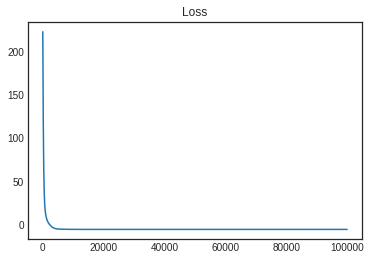

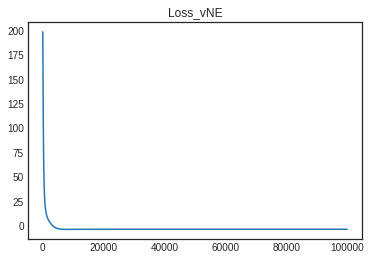

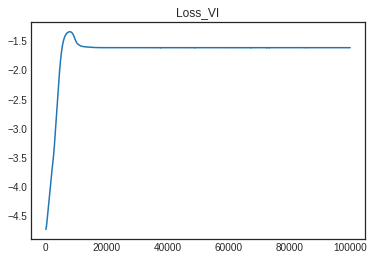

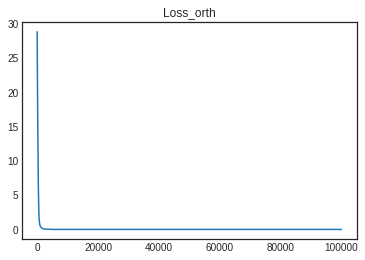

In [23]:
plt.plot(np.arange(epochs), loss_hist)
plt.title("Loss")
plt.show()
plt.plot(np.arange(epochs), loss_vNE_hist)
plt.title("Loss_vNE")
plt.show()
plt.plot(np.arange(epochs), loss_VI_hist)
plt.title("Loss_VI")
plt.show()
plt.plot(np.arange(epochs), loss_orth_hist)
plt.title("Loss_orth")
plt.show()

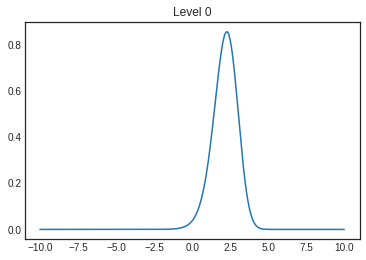

Square integrated over the region: 1.000000000000021


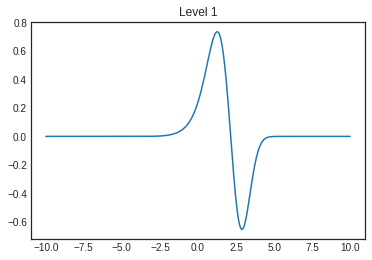

Square integrated over the region: 1.0000000000000209


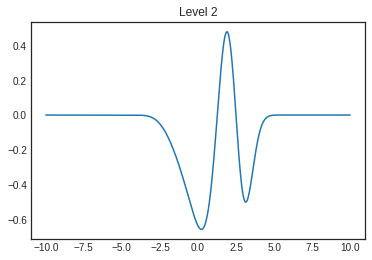

Square integrated over the region: 1.0000000000000209


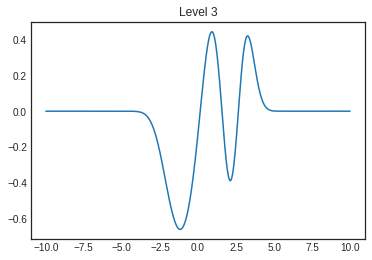

Square integrated over the region: 1.000000000000021


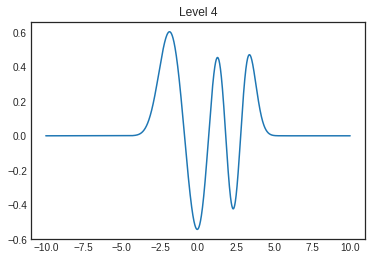

Square integrated over the region: 1.000000000000021


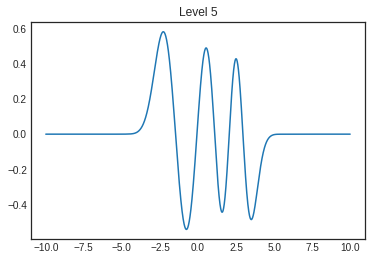

Square integrated over the region: 1.0000000000000213


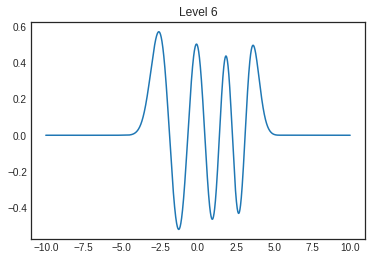

Square integrated over the region: 1.0000000000000213


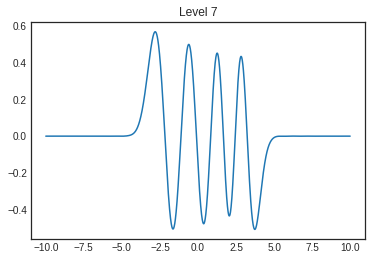

Square integrated over the region: 1.0000000000000215


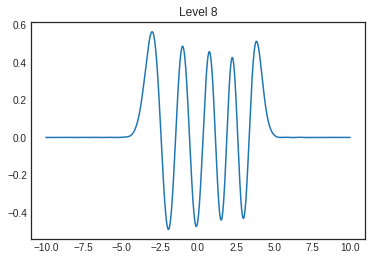

Square integrated over the region: 1.000000000000021


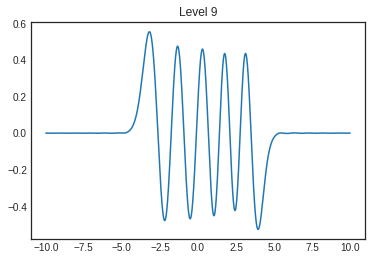

Square integrated over the region: 1.0000000000000215


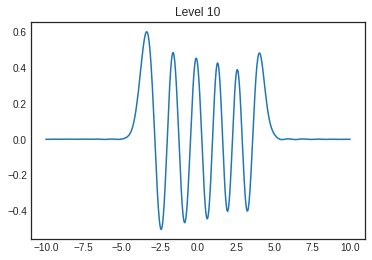

Square integrated over the region: 1.0000000000000213


In [24]:
x = np.arange(-10, 10 , 0.01)
k = n_FM
L = box_len
Y = FM(k, L, x)

SUP = np.matmul(Y, var_FC_N)

for i in range(11):
    plt.plot(x, SUP[:, i])
    plt.title("Level " + str(i))
    plt.show()
    print("Square integrated over the region: " + str(np.sum(SUP[:, i] * SUP[:, i]) * 0.01)) #check wavefunction normalisation

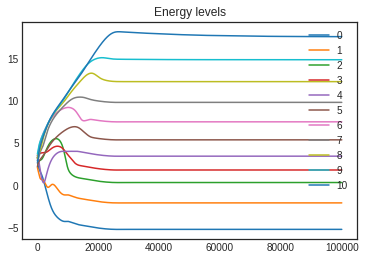

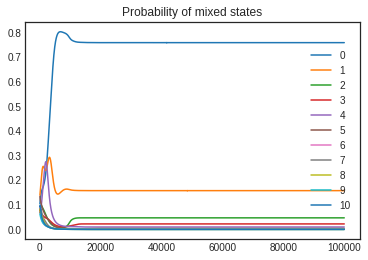

In [25]:
for i in range(n_EL+1):
    plt.plot(np.arange(epochs), levels_hist[:,i]*T, label = str(i))

plt.title("Energy levels")    
plt.legend()
plt.show()

for i in range(n_EL+1):
    plt.plot(np.arange(epochs), logits_hist[:,i], label = str(i))

plt.title("Probability of mixed states")    
plt.legend()
plt.show()

In [26]:
print("Energy: ")
print(levels_fin)
print("Probabilities: ")
print(logits_fin)

Energy: 
[-2.61933168 -1.04730926  0.16194502  0.90567249  1.72562488  2.69549863
  3.76475822  4.91992266  6.15072277  7.45050725  8.82049322]
Probabilities: 
[7.57946414e-01 1.57368512e-01 4.69618696e-02 2.23227985e-02
 9.83213520e-03 3.72766630e-03 1.27956833e-03 4.03071361e-04
 1.17720541e-04 3.20895052e-05 8.15428096e-06]


## Higher temperature (T = 4)

In [18]:
n_FM = 20
box_len = 10

H_AHO_FM = H_AHO_FM_int(n_FM, box_len,  V_AHO)

In [17]:
n_EL = 10
T = 4
qvi_AHO_FM = QVI(T, n_EL, H_AHO_FM)
epochs = 100000
step = 1e-3

[loss_hist, loss_vNE_hist, loss_VI_hist, loss_orth_hist, levels_hist, logits_hist, var_FC_N, levels_fin, logits_fin] = \
                                                                main_train_states_QVI(qvi_AHO_FM, epochs, step)

Batch number  0
Loss:  225.2054912763711
Loss_orth:  29.641409597249563
Loss_vNE:  205.030274667868
Loss_vI:  -9.466192988746494
@----------------------------------------------------------@
Batch number  10000
Loss:  -7.68526819692983
Loss_orth:  0.0002643116772288507
Loss_vNE:  -1.387965926955387
Loss_vI:  -6.297566581651672
@----------------------------------------------------------@
Batch number  20000
Loss:  -7.731617997437574
Loss_orth:  6.825860050461052e-08
Loss_vNE:  -1.3873542356894863
Loss_vI:  -6.344263830006689
@----------------------------------------------------------@
Batch number  30000
Loss:  -7.731617320729891
Loss_orth:  3.5773163351998814e-07
Loss_vNE:  -1.387349812091994
Loss_vI:  -6.34426786636953
@----------------------------------------------------------@
Batch number  40000
Loss:  -7.7316189997371065
Loss_orth:  1.2896201575635173e-07
Loss_vNE:  -1.3873454717380904
Loss_vI:  -6.3442736569610325
@----------------------------------------------------------@
Batch 

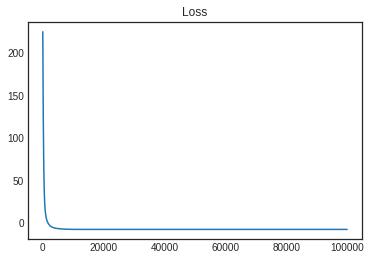

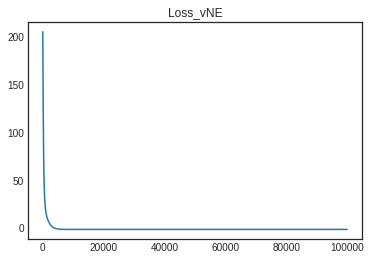

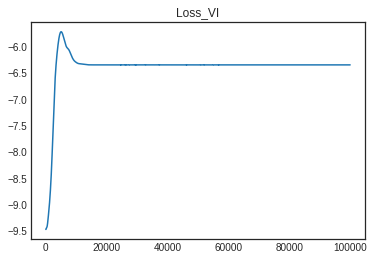

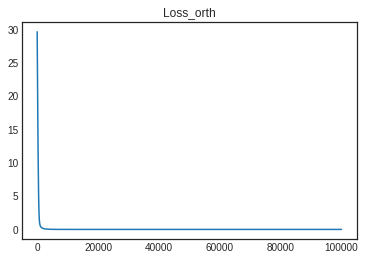

In [18]:
plt.plot(np.arange(epochs), loss_hist)
plt.title("Loss")
plt.show()
plt.plot(np.arange(epochs), loss_vNE_hist)
plt.title("Loss_vNE")
plt.show()
plt.plot(np.arange(epochs), loss_VI_hist)
plt.title("Loss_VI")
plt.show()
plt.plot(np.arange(epochs), loss_orth_hist)
plt.title("Loss_orth")
plt.show()

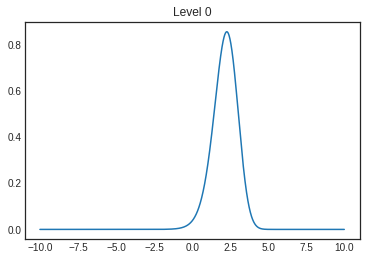

Square integrated over the region: 1.000000000000021


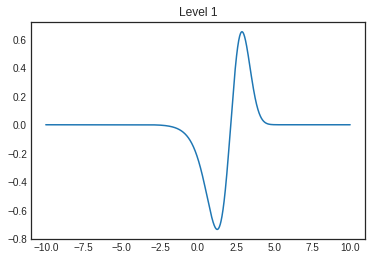

Square integrated over the region: 1.0000000000000209


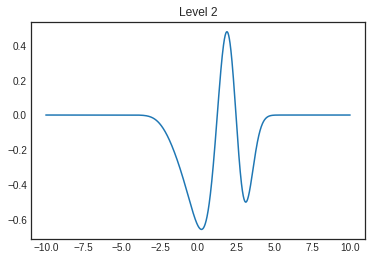

Square integrated over the region: 1.000000000000021


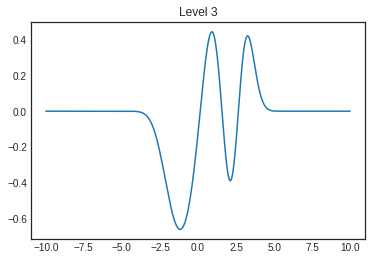

Square integrated over the region: 1.0000000000000213


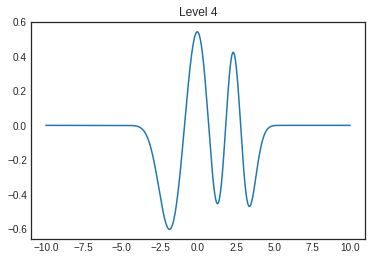

Square integrated over the region: 1.0000000000000209


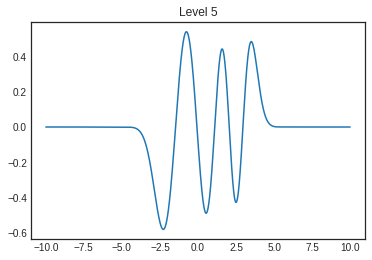

Square integrated over the region: 1.0000000000000215


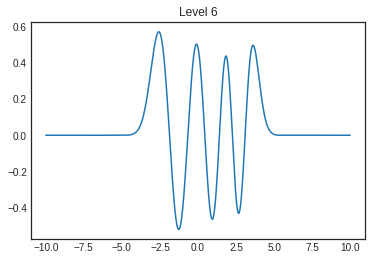

Square integrated over the region: 1.0000000000000209


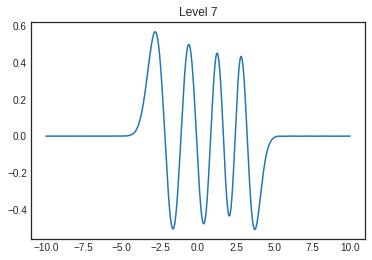

Square integrated over the region: 1.000000000000021


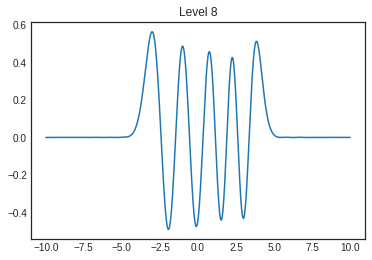

Square integrated over the region: 1.000000000000021


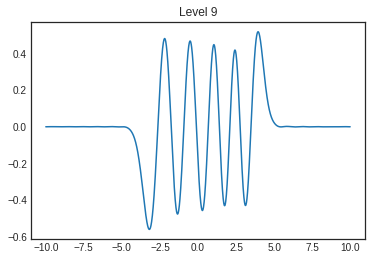

Square integrated over the region: 1.000000000000021


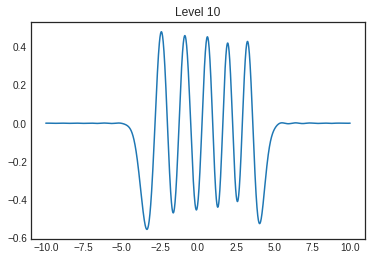

Square integrated over the region: 1.000000000000021


In [19]:
x = np.arange(-10, 10 , 0.01)
k = n_FM
L = box_len
Y = FM(k, L, x)

SUP = np.matmul(Y, var_FC_N)

for i in range(11):
    plt.plot(x, SUP[:, i])
    plt.title("Level " + str(i))
    plt.show()
    print("Square integrated over the region: " + str(np.sum(SUP[:, i] * SUP[:, i]) * 0.01)) #check wavefunction normalisation

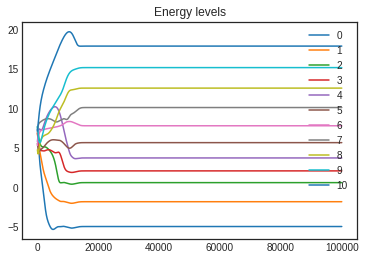

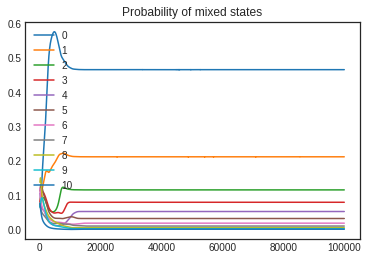

In [20]:
for i in range(n_EL+1):
    plt.plot(np.arange(epochs), levels_hist[:,i]*T, label = str(i))

plt.title("Energy levels")    
plt.legend()
plt.show()

for i in range(n_EL+1):
    plt.plot(np.arange(epochs), logits_hist[:,i], label = str(i))

plt.title("Probability of mixed states")    
plt.legend()
plt.show()

In [21]:
print("Energy: ")
print(levels_fin)
print("Probabilities: ")
print(logits_fin)

Energy: 
[-1.24537693 -0.4593704   0.14525604  0.51712047  0.92709671  1.41203368
  1.94666355  2.52424611  3.13964701  3.78940331  4.47094691]
Probabilities: 
[0.46584645 0.21226798 0.11595742 0.07994658 0.05305783 0.03266962
 0.01914067 0.01074277 0.00580565 0.00303156 0.00153347]
